# install library

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [2]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 4.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=1c955bde4e555c856f86bb5a39c0873ab9e12ed431adbc7e2853c1f3d59a7a17
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 35% 5.00M/14.3M [00:00<00:00, 29.1MB/s]
100% 14.3M/14.3M [00:00<00:00, 58.0MB/s]
 90% 105M/117M [00:02<00:00, 46.8MB/s] 
100% 117M/117M [00:02<00:00, 46.6MB/s]


In [3]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 9.8 MB/s 
     |████████████████████████████████| 948 kB 67.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=72e2edb090bb6d4158cfd9f8a0c52883324af2b5b5f7c266a4ede9d5e845ba70
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [4]:
class Config:
    Version = "exp37" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    # MODEL_NAME = "swin_large_patch4_window7_224"
    # MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    # MODEL_NAME = "swin_large_patch4_window12_384"
    # MODEL_NAME = "swin_base_patch4_window12_384"
    # MODEL_NAME = "vit_base_patch16_224"
    #MODEL_NAME = 'nfnet_f1'



    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'vit_base_patch16_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'nfnet_f1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  64 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    gamma = 2 
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [5]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [7]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [8]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [9]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [10]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [11]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            # A.VerticalFlip(p=0.5),
            # A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [12]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.num_features#fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# Loss

In [13]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=Config.gamma, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

# train & valid function

In [14]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [15]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [16]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

image_id  label
0  ../input/animal-imbalance-classification-round...      0
1  ../input/animal-imbalance-classification-round...      0
2  ../input/animal-imbalance-classification-round...      0
3  ../input/animal-imbalance-classification-round...      0
4  ../input/animal-imbalance-classification-round...      0

In [17]:
#train['image_id'][0]

In [18]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [19]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [20]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

image_id  label  folds
0      ../input/animal-imbalance-classification-round...      0      1
1      ../input/animal-imbalance-classification-round...      0      1
2      ../input/animal-imbalance-classification-round...      0      1
3      ../input/animal-imbalance-classification-round...      0      1
4      ../input/animal-imbalance-classification-round...      0      0
...                                                  ...    ...    ...
36495  ../input/animal-imbalance-classification-round...      9      1
36496  ../input/animal-imbalance-classification-round...      9      1
36497  ../input/animal-imbalance-classification-round...      9      1
36498  ../input/animal-imbalance-classification-round...      9      1
36499  ../input/animal-imbalance-classification-round...      9      0

[36500 rows x 3 columns]

#### 平均と標準偏差を計算

In [21]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [22]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [23]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [24]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_runnin

### 最適化関数

In [25]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

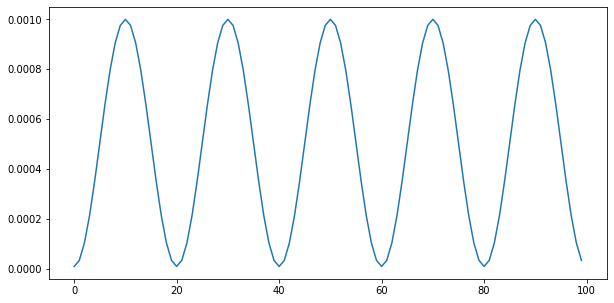

In [26]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

# 学習

In [27]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion =  FocalLoss() #nn.CrossEntropyLoss() # loss function

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [28]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/456] Data 0.763 (0.763) Elapsed 0m 1s (remain 11m 36s) Loss: 1.9206(1.9206) 
Epoch: [1][455/456] Data 0.000 (0.002) Elapsed 2m 43s (remain 0m 0s) Loss: 1.8064(1.8455) 
EVAL: [0/115] Data 0.411 (0.411) Elapsed 0m 0s (remain 1m 0s) Loss: 1.7870(1.7870) 


Epoch 1 - avg_train_loss: 1.8455  avg_val_loss: 1.8992  time: 173s


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 2.0971(1.8992) 


Epoch 1 - Accuracy: 0.14205479452054795
Epoch 1 - Save Best Score: 0.1421 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [2][0/456] Data 0.527 (0.527) Elapsed 0m 0s (remain 7m 22s) Loss: 1.7963(1.7963) 
Epoch: [2][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 1.4308(1.6321) 
EVAL: [0/115] Data 0.379 (0.379) Elapsed 0m 0s (remain 0m 53s) Loss: 0.6197(0.6197) 


Epoch 2 - avg_train_loss: 1.6321  avg_val_loss: 1.5402  time: 173s
Epoch 2 - Accuracy: 0.27164383561643834
Epoch 2 - Save Best Score: 0.2716 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 3.7560(1.5402) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [3][0/456] Data 0.434 (0.434) Elapsed 0m 0s (remain 6m 44s) Loss: 1.3246(1.3246) 
Epoch: [3][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.7619(1.1181) 
EVAL: [0/115] Data 0.418 (0.418) Elapsed 0m 0s (remain 0m 56s) Loss: 0.8047(0.8047) 


Epoch 3 - avg_train_loss: 1.1181  avg_val_loss: 0.9797  time: 173s
Epoch 3 - Accuracy: 0.45643835616438355
Epoch 3 - Save Best Score: 0.4564 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 2.1950(0.9797) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [4][0/456] Data 0.443 (0.443) Elapsed 0m 0s (remain 7m 4s) Loss: 0.9590(0.9590) 
Epoch: [4][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 1.0009(0.9012) 
EVAL: [0/115] Data 0.373 (0.373) Elapsed 0m 0s (remain 0m 53s) Loss: 0.4946(0.4946) 


Epoch 4 - avg_train_loss: 0.9012  avg_val_loss: 0.8106  time: 173s
Epoch 4 - Accuracy: 0.5267123287671233


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 2.1619(0.8106) 


Epoch 4 - Save Best Score: 0.5267 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [5][0/456] Data 0.435 (0.435) Elapsed 0m 0s (remain 6m 57s) Loss: 0.9914(0.9914) 
Epoch: [5][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.6758(0.7706) 
EVAL: [0/115] Data 0.359 (0.359) Elapsed 0m 0s (remain 0m 50s) Loss: 0.5099(0.5099) 


Epoch 5 - avg_train_loss: 0.7706  avg_val_loss: 0.6695  time: 173s
Epoch 5 - Accuracy: 0.5953424657534246
Epoch 5 - Save Best Score: 0.5953 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 1.0044(0.6695) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [6][0/456] Data 0.466 (0.466) Elapsed 0m 0s (remain 7m 22s) Loss: 0.5685(0.5685) 
Epoch: [6][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.4735(0.6244) 
EVAL: [0/115] Data 0.410 (0.410) Elapsed 0m 0s (remain 0m 58s) Loss: 0.3030(0.3030) 


Epoch 6 - avg_train_loss: 0.6244  avg_val_loss: 0.5533  time: 173s
Epoch 6 - Accuracy: 0.6561643835616439
Epoch 6 - Save Best Score: 0.6562 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.3584(0.5533) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [7][0/456] Data 0.488 (0.488) Elapsed 0m 0s (remain 7m 13s) Loss: 0.6008(0.6008) 
Epoch: [7][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.3669(0.5025) 
EVAL: [0/115] Data 0.364 (0.364) Elapsed 0m 0s (remain 0m 51s) Loss: 0.3496(0.3496) 


Epoch 7 - avg_train_loss: 0.5025  avg_val_loss: 0.4650  time: 173s
Epoch 7 - Accuracy: 0.711917808219178
Epoch 7 - Save Best Score: 0.7119 Model


EVAL: [114/115] Data 0.000 (0.003) Elapsed 0m 9s (remain 0m 0s) Loss: 0.7572(0.4650) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [8][0/456] Data 0.554 (0.554) Elapsed 0m 0s (remain 7m 15s) Loss: 0.5429(0.5429) 
Epoch: [8][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.4171(0.4057) 
EVAL: [0/115] Data 0.374 (0.374) Elapsed 0m 0s (remain 0m 51s) Loss: 0.1841(0.1841) 


Epoch 8 - avg_train_loss: 0.4057  avg_val_loss: 0.4304  time: 173s
Epoch 8 - Accuracy: 0.7293150684931506
Epoch 8 - Save Best Score: 0.7293 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.1547(0.4304) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [9][0/456] Data 0.488 (0.488) Elapsed 0m 0s (remain 7m 21s) Loss: 0.3437(0.3437) 
Epoch: [9][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.2661(0.3366) 
EVAL: [0/115] Data 0.407 (0.407) Elapsed 0m 0s (remain 0m 58s) Loss: 0.2066(0.2066) 


Epoch 9 - avg_train_loss: 0.3366  avg_val_loss: 0.3968  time: 173s
Epoch 9 - Accuracy: 0.7589041095890411
Epoch 9 - Save Best Score: 0.7589 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.2162(0.3968) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [10][0/456] Data 0.493 (0.493) Elapsed 0m 0s (remain 6m 55s) Loss: 0.2124(0.2124) 
Epoch: [10][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1117(0.2805) 
EVAL: [0/115] Data 0.361 (0.361) Elapsed 0m 0s (remain 0m 51s) Loss: 0.2260(0.2260) 
EVAL: [114/115] Data 0.000 (0.003) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0475(0.3407) 


Epoch 10 - avg_train_loss: 0.2805  avg_val_loss: 0.3407  time: 173s
Epoch 10 - Accuracy: 0.7887671232876712
Epoch 10 - Save Best Score: 0.7888 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [11][0/456] Data 0.471 (0.471) Elapsed 0m 0s (remain 6m 45s) Loss: 0.2071(0.2071) 
Epoch: [11][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1491(0.2333) 
EVAL: [0/115] Data 0.386 (0.386) Elapsed 0m 0s (remain 0m 53s) Loss: 0.4459(0.4459) 


Epoch 11 - avg_train_loss: 0.2333  avg_val_loss: 0.3462  time: 173s
Epoch 11 - Accuracy: 0.7842465753424658


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.3274(0.3462) 
Epoch: [12][0/456] Data 0.519 (0.519) Elapsed 0m 0s (remain 7m 27s) Loss: 0.2107(0.2107) 
Epoch: [12][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.2971(0.1864) 
EVAL: [0/115] Data 0.405 (0.405) Elapsed 0m 0s (remain 0m 55s) Loss: 0.1126(0.1126) 


Epoch 12 - avg_train_loss: 0.1864  avg_val_loss: 0.3406  time: 173s
Epoch 12 - Accuracy: 0.7893150684931507
Epoch 12 - Save Best Score: 0.7893 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.2760(0.3406) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [13][0/456] Data 0.608 (0.608) Elapsed 0m 1s (remain 7m 56s) Loss: 0.1396(0.1396) 
Epoch: [13][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1203(0.1408) 
EVAL: [0/115] Data 0.378 (0.378) Elapsed 0m 0s (remain 0m 54s) Loss: 0.1054(0.1054) 


Epoch 13 - avg_train_loss: 0.1408  avg_val_loss: 0.3511  time: 173s
Epoch 13 - Accuracy: 0.7984931506849315
Epoch 13 - Save Best Score: 0.7985 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.2638(0.3511) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [14][0/456] Data 0.482 (0.482) Elapsed 0m 0s (remain 6m 50s) Loss: 0.0827(0.0827) 
Epoch: [14][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1501(0.1017) 
EVAL: [0/115] Data 0.398 (0.398) Elapsed 0m 0s (remain 0m 54s) Loss: 0.2344(0.2344) 


Epoch 14 - avg_train_loss: 0.1017  avg_val_loss: 0.3915  time: 173s
Epoch 14 - Accuracy: 0.7893150684931507


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0060(0.3915) 
Epoch: [15][0/456] Data 0.544 (0.544) Elapsed 0m 0s (remain 7m 3s) Loss: 0.1390(0.1390) 
Epoch: [15][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1716(0.0686) 
EVAL: [0/115] Data 0.480 (0.480) Elapsed 0m 0s (remain 1m 4s) Loss: 0.1261(0.1261) 


Epoch 15 - avg_train_loss: 0.0686  avg_val_loss: 0.3339  time: 173s
Epoch 15 - Accuracy: 0.8283561643835616
Epoch 15 - Save Best Score: 0.8284 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0598(0.3339) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [16][0/456] Data 0.508 (0.508) Elapsed 0m 0s (remain 7m 20s) Loss: 0.0503(0.0503) 
Epoch: [16][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0767(0.0367) 
EVAL: [0/115] Data 0.374 (0.374) Elapsed 0m 0s (remain 0m 58s) Loss: 0.2080(0.2080) 


Epoch 16 - avg_train_loss: 0.0367  avg_val_loss: 0.3430  time: 173s


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0486(0.3430) 


Epoch 16 - Accuracy: 0.8313698630136986
Epoch 16 - Save Best Score: 0.8314 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [17][0/456] Data 0.535 (0.535) Elapsed 0m 1s (remain 7m 35s) Loss: 0.0225(0.0225) 
Epoch: [17][455/456] Data 0.000 (0.001) Elapsed 2m 43s (remain 0m 0s) Loss: 0.0529(0.0199) 
EVAL: [0/115] Data 0.437 (0.437) Elapsed 0m 0s (remain 0m 59s) Loss: 0.1839(0.1839) 


Epoch 17 - avg_train_loss: 0.0199  avg_val_loss: 0.3332  time: 173s


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0134(0.3332) 


Epoch 17 - Accuracy: 0.8464383561643836
Epoch 17 - Save Best Score: 0.8464 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [18][0/456] Data 0.473 (0.473) Elapsed 0m 0s (remain 7m 19s) Loss: 0.0041(0.0041) 
Epoch: [18][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0073(0.0108) 
EVAL: [0/115] Data 0.436 (0.436) Elapsed 0m 0s (remain 0m 59s) Loss: 0.2132(0.2132) 


Epoch 18 - avg_train_loss: 0.0108  avg_val_loss: 0.3417  time: 173s
Epoch 18 - Accuracy: 0.8497260273972602
Epoch 18 - Save Best Score: 0.8497 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0015(0.3417) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [19][0/456] Data 0.494 (0.494) Elapsed 0m 0s (remain 7m 21s) Loss: 0.0014(0.0014) 
Epoch: [19][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0024(0.0075) 
EVAL: [0/115] Data 0.412 (0.412) Elapsed 0m 0s (remain 0m 56s) Loss: 0.1762(0.1762) 


Epoch 19 - avg_train_loss: 0.0075  avg_val_loss: 0.3314  time: 173s
Epoch 19 - Accuracy: 0.8554794520547945


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0872(0.3314) 


Epoch 19 - Save Best Score: 0.8555 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [20][0/456] Data 0.476 (0.476) Elapsed 0m 0s (remain 7m 30s) Loss: 0.0014(0.0014) 
Epoch: [20][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0078(0.0054) 
EVAL: [0/115] Data 0.439 (0.439) Elapsed 0m 0s (remain 0m 59s) Loss: 0.1435(0.1435) 


Epoch 20 - avg_train_loss: 0.0054  avg_val_loss: 0.3283  time: 173s
Epoch 20 - Accuracy: 0.8534246575342466


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0188(0.3283) 
Epoch: [21][0/456] Data 0.501 (0.501) Elapsed 0m 0s (remain 6m 37s) Loss: 0.0020(0.0020) 
Epoch: [21][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0036(0.0043) 
EVAL: [0/115] Data 0.357 (0.357) Elapsed 0m 0s (remain 0m 49s) Loss: 0.1870(0.1870) 


Epoch 21 - avg_train_loss: 0.0043  avg_val_loss: 0.3232  time: 173s


EVAL: [114/115] Data 0.000 (0.003) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0370(0.3232) 


Epoch 21 - Accuracy: 0.8582191780821918
Epoch 21 - Save Best Score: 0.8582 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [22][0/456] Data 0.475 (0.475) Elapsed 0m 0s (remain 6m 44s) Loss: 0.0055(0.0055) 
Epoch: [22][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0004(0.0043) 
EVAL: [0/115] Data 0.366 (0.366) Elapsed 0m 0s (remain 0m 52s) Loss: 0.1886(0.1886) 


Epoch 22 - avg_train_loss: 0.0043  avg_val_loss: 0.3233  time: 173s


EVAL: [114/115] Data 0.000 (0.003) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0243(0.3233) 


Epoch 22 - Accuracy: 0.8558904109589041


Epoch: [23][0/456] Data 0.494 (0.494) Elapsed 0m 0s (remain 7m 19s) Loss: 0.0019(0.0019) 
Epoch: [23][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0007(0.0052) 
EVAL: [0/115] Data 0.393 (0.393) Elapsed 0m 0s (remain 0m 53s) Loss: 0.2081(0.2081) 


Epoch 23 - avg_train_loss: 0.0052  avg_val_loss: 0.3425  time: 173s
Epoch 23 - Accuracy: 0.8536986301369863


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0225(0.3425) 
Epoch: [24][0/456] Data 0.521 (0.521) Elapsed 0m 0s (remain 7m 33s) Loss: 0.0012(0.0012) 
Epoch: [24][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1168(0.0159) 
EVAL: [0/115] Data 0.386 (0.386) Elapsed 0m 0s (remain 0m 55s) Loss: 0.4484(0.4484) 


Epoch 24 - avg_train_loss: 0.0159  avg_val_loss: 0.3902  time: 173s
Epoch 24 - Accuracy: 0.8343835616438356


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0034(0.3902) 
Epoch: [25][0/456] Data 0.410 (0.410) Elapsed 0m 0s (remain 6m 46s) Loss: 0.0008(0.0008) 
Epoch: [25][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0317(0.0363) 
EVAL: [0/115] Data 0.363 (0.363) Elapsed 0m 0s (remain 0m 50s) Loss: 0.2450(0.2450) 


Epoch 25 - avg_train_loss: 0.0363  avg_val_loss: 0.3768  time: 173s
Epoch 25 - Accuracy: 0.8309589041095891


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.1044(0.3768) 
Epoch: [26][0/456] Data 0.463 (0.463) Elapsed 0m 0s (remain 6m 58s) Loss: 0.0157(0.0157) 
Epoch: [26][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0187(0.0555) 
EVAL: [0/115] Data 0.334 (0.334) Elapsed 0m 0s (remain 0m 49s) Loss: 0.2270(0.2270) 


Epoch 26 - avg_train_loss: 0.0555  avg_val_loss: 0.3598  time: 173s
Epoch 26 - Accuracy: 0.8265753424657534


EVAL: [114/115] Data 0.000 (0.003) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0104(0.3598) 
Epoch: [27][0/456] Data 0.442 (0.442) Elapsed 0m 0s (remain 6m 48s) Loss: 0.0321(0.0321) 
Epoch: [27][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1255(0.0628) 
EVAL: [0/115] Data 0.376 (0.376) Elapsed 0m 0s (remain 0m 54s) Loss: 0.3806(0.3806) 


Epoch 27 - avg_train_loss: 0.0628  avg_val_loss: 0.3708  time: 173s
Epoch 27 - Accuracy: 0.8217808219178082


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.3913(0.3708) 
Epoch: [28][0/456] Data 0.493 (0.493) Elapsed 0m 0s (remain 7m 13s) Loss: 0.0237(0.0237) 
Epoch: [28][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0182(0.0775) 
EVAL: [0/115] Data 0.416 (0.416) Elapsed 0m 0s (remain 0m 59s) Loss: 0.2877(0.2877) 


Epoch 28 - avg_train_loss: 0.0775  avg_val_loss: 0.4054  time: 173s
Epoch 28 - Accuracy: 0.8002739726027397


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.4181(0.4054) 
Epoch: [29][0/456] Data 0.456 (0.456) Elapsed 0m 0s (remain 7m 18s) Loss: 0.0655(0.0655) 
Epoch: [29][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0419(0.0714) 
EVAL: [0/115] Data 0.366 (0.366) Elapsed 0m 0s (remain 0m 54s) Loss: 0.2659(0.2659) 


Epoch 29 - avg_train_loss: 0.0714  avg_val_loss: 0.3644  time: 173s
Epoch 29 - Accuracy: 0.8252054794520548


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.3544(0.3644) 
Epoch: [30][0/456] Data 0.477 (0.477) Elapsed 0m 0s (remain 6m 26s) Loss: 0.0673(0.0673) 
Epoch: [30][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1577(0.0722) 
EVAL: [0/115] Data 0.401 (0.401) Elapsed 0m 0s (remain 0m 55s) Loss: 0.1914(0.1914) 


Epoch 30 - avg_train_loss: 0.0722  avg_val_loss: 0.3491  time: 173s
Epoch 30 - Accuracy: 0.8189041095890411


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0017(0.3491) 
Epoch: [31][0/456] Data 0.444 (0.444) Elapsed 0m 0s (remain 7m 8s) Loss: 0.0346(0.0346) 
Epoch: [31][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.1139(0.0639) 
EVAL: [0/115] Data 0.477 (0.477) Elapsed 0m 0s (remain 1m 3s) Loss: 0.1500(0.1500) 


Epoch 31 - avg_train_loss: 0.0639  avg_val_loss: 0.3744  time: 173s
Epoch 31 - Accuracy: 0.8153424657534246


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0284(0.3744) 
Epoch: [32][0/456] Data 0.452 (0.452) Elapsed 0m 0s (remain 6m 56s) Loss: 0.0999(0.0999) 
Epoch: [32][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0582(0.0564) 
EVAL: [0/115] Data 0.429 (0.429) Elapsed 0m 0s (remain 0m 57s) Loss: 0.2348(0.2348) 


Epoch 32 - avg_train_loss: 0.0564  avg_val_loss: 0.3466  time: 173s
Epoch 32 - Accuracy: 0.823013698630137


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0079(0.3466) 
Epoch: [33][0/456] Data 0.427 (0.427) Elapsed 0m 0s (remain 6m 24s) Loss: 0.0100(0.0100) 
Epoch: [33][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0573(0.0380) 
EVAL: [0/115] Data 0.412 (0.412) Elapsed 0m 0s (remain 0m 57s) Loss: 0.2293(0.2293) 


Epoch 33 - avg_train_loss: 0.0380  avg_val_loss: 0.3589  time: 173s
Epoch 33 - Accuracy: 0.8235616438356165


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0277(0.3589) 
Epoch: [34][0/456] Data 0.521 (0.521) Elapsed 0m 0s (remain 7m 19s) Loss: 0.0236(0.0236) 
Epoch: [34][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0222(0.0298) 
EVAL: [0/115] Data 0.492 (0.492) Elapsed 0m 0s (remain 1m 5s) Loss: 0.1439(0.1439) 


Epoch 34 - avg_train_loss: 0.0298  avg_val_loss: 0.3585  time: 173s


EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0505(0.3585) 


Epoch 34 - Accuracy: 0.8380821917808219


Epoch: [35][0/456] Data 0.455 (0.455) Elapsed 0m 0s (remain 7m 20s) Loss: 0.0144(0.0144) 
Epoch: [35][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0145(0.0212) 
EVAL: [0/115] Data 0.502 (0.502) Elapsed 0m 0s (remain 1m 6s) Loss: 0.0964(0.0964) 


Epoch 35 - avg_train_loss: 0.0212  avg_val_loss: 0.3420  time: 173s
Epoch 35 - Accuracy: 0.8427397260273972


EVAL: [114/115] Data 0.000 (0.005) Elapsed 0m 9s (remain 0m 0s) Loss: 0.2157(0.3420) 
Epoch: [36][0/456] Data 0.519 (0.519) Elapsed 0m 0s (remain 7m 24s) Loss: 0.0112(0.0112) 
Epoch: [36][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0031(0.0126) 
EVAL: [0/115] Data 0.370 (0.370) Elapsed 0m 0s (remain 0m 55s) Loss: 0.1401(0.1401) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0016(0.3269) 


Epoch 36 - avg_train_loss: 0.0126  avg_val_loss: 0.3269  time: 173s
Epoch 36 - Accuracy: 0.8535616438356164


Epoch: [37][0/456] Data 0.444 (0.444) Elapsed 0m 0s (remain 7m 0s) Loss: 0.0441(0.0441) 
Epoch: [37][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0027(0.0070) 
EVAL: [0/115] Data 0.365 (0.365) Elapsed 0m 0s (remain 0m 51s) Loss: 0.1937(0.1937) 


Epoch 37 - avg_train_loss: 0.0070  avg_val_loss: 0.3274  time: 173s
Epoch 37 - Accuracy: 0.8568493150684932


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0007(0.3274) 
Epoch: [38][0/456] Data 0.445 (0.445) Elapsed 0m 0s (remain 6m 36s) Loss: 0.0135(0.0135) 
Epoch: [38][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0004(0.0041) 
EVAL: [0/115] Data 0.378 (0.378) Elapsed 0m 0s (remain 0m 52s) Loss: 0.1314(0.1314) 


Epoch 38 - avg_train_loss: 0.0041  avg_val_loss: 0.3301  time: 173s
Epoch 38 - Accuracy: 0.8656164383561644
Epoch 38 - Save Best Score: 0.8656 Model


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0002(0.3301) 
/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [39][0/456] Data 0.460 (0.460) Elapsed 0m 0s (remain 6m 35s) Loss: 0.0042(0.0042) 
Epoch: [39][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0033(0.0032) 
EVAL: [0/115] Data 0.376 (0.376) Elapsed 0m 0s (remain 0m 56s) Loss: 0.1432(0.1432) 


Epoch 39 - avg_train_loss: 0.0032  avg_val_loss: 0.3216  time: 173s


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0008(0.3216) 


Epoch 39 - Accuracy: 0.8693150684931507
Epoch 39 - Save Best Score: 0.8693 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp37/tf_efficientnet_b1_ns_fold0_best_exp37.pth saved
Epoch: [40][0/456] Data 0.461 (0.461) Elapsed 0m 0s (remain 6m 44s) Loss: 0.0002(0.0002) 
Epoch: [40][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0008(0.0019) 
EVAL: [0/115] Data 0.440 (0.440) Elapsed 0m 0s (remain 0m 59s) Loss: 0.1430(0.1430) 


Epoch 40 - avg_train_loss: 0.0019  avg_val_loss: 0.3215  time: 173s
Epoch 40 - Accuracy: 0.8675342465753425


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0012(0.3215) 
Epoch: [41][0/456] Data 0.533 (0.533) Elapsed 0m 0s (remain 7m 26s) Loss: 0.0156(0.0156) 
Epoch: [41][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0004(0.0016) 
EVAL: [0/115] Data 0.383 (0.383) Elapsed 0m 0s (remain 0m 52s) Loss: 0.1407(0.1407) 


Epoch 41 - avg_train_loss: 0.0016  avg_val_loss: 0.3181  time: 173s
Epoch 41 - Accuracy: 0.8689041095890411


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0017(0.3181) 
Epoch: [42][0/456] Data 0.494 (0.494) Elapsed 0m 0s (remain 7m 5s) Loss: 0.0004(0.0004) 
Epoch: [42][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0012(0.0019) 
EVAL: [0/115] Data 0.450 (0.450) Elapsed 0m 0s (remain 1m 2s) Loss: 0.1332(0.1332) 


Epoch 42 - avg_train_loss: 0.0019  avg_val_loss: 0.3195  time: 173s
Epoch 42 - Accuracy: 0.8684931506849315


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0033(0.3195) 
Epoch: [43][0/456] Data 0.506 (0.506) Elapsed 0m 0s (remain 7m 7s) Loss: 0.0020(0.0020) 
Epoch: [43][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0000(0.0020) 
EVAL: [0/115] Data 0.434 (0.434) Elapsed 0m 0s (remain 0m 59s) Loss: 0.1399(0.1399) 


Epoch 43 - avg_train_loss: 0.0020  avg_val_loss: 0.3242  time: 173s


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0007(0.3242) 


Epoch 43 - Accuracy: 0.8665753424657534


Epoch: [44][0/456] Data 0.558 (0.558) Elapsed 0m 0s (remain 7m 25s) Loss: 0.0018(0.0018) 
Epoch: [44][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0007(0.0042) 
EVAL: [0/115] Data 0.347 (0.347) Elapsed 0m 0s (remain 0m 48s) Loss: 0.1885(0.1885) 
EVAL: [114/115] Data 0.000 (0.003) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0031(0.3658) 


Epoch 44 - avg_train_loss: 0.0042  avg_val_loss: 0.3658  time: 173s
Epoch 44 - Accuracy: 0.856027397260274


Epoch: [45][0/456] Data 0.539 (0.539) Elapsed 0m 1s (remain 7m 39s) Loss: 0.0006(0.0006) 
Epoch: [45][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0212(0.0185) 
EVAL: [0/115] Data 0.470 (0.470) Elapsed 0m 0s (remain 1m 3s) Loss: 0.1829(0.1829) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.6420(0.3514) 


Epoch 45 - avg_train_loss: 0.0185  avg_val_loss: 0.3514  time: 173s
Epoch 45 - Accuracy: 0.8523287671232876


Epoch: [46][0/456] Data 0.554 (0.554) Elapsed 0m 0s (remain 7m 20s) Loss: 0.0127(0.0127) 
Epoch: [46][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0104(0.0254) 
EVAL: [0/115] Data 0.442 (0.442) Elapsed 0m 0s (remain 1m 1s) Loss: 0.2842(0.2842) 
EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0165(0.3542) 


Epoch 46 - avg_train_loss: 0.0254  avg_val_loss: 0.3542  time: 173s
Epoch 46 - Accuracy: 0.8405479452054795


Epoch: [47][0/456] Data 0.496 (0.496) Elapsed 0m 0s (remain 7m 19s) Loss: 0.0135(0.0135) 
Epoch: [47][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0275(0.0366) 
EVAL: [0/115] Data 0.428 (0.428) Elapsed 0m 0s (remain 0m 59s) Loss: 0.1756(0.1756) 


Epoch 47 - avg_train_loss: 0.0366  avg_val_loss: 0.3429  time: 173s
Epoch 47 - Accuracy: 0.8443835616438357


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.1504(0.3429) 
Epoch: [48][0/456] Data 0.564 (0.564) Elapsed 0m 1s (remain 7m 39s) Loss: 0.0116(0.0116) 
Epoch: [48][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0251(0.0404) 
EVAL: [0/115] Data 0.418 (0.418) Elapsed 0m 0s (remain 0m 56s) Loss: 0.1373(0.1373) 


Epoch 48 - avg_train_loss: 0.0404  avg_val_loss: 0.4048  time: 173s
Epoch 48 - Accuracy: 0.8158904109589041


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0000(0.4048) 
Epoch: [49][0/456] Data 0.497 (0.497) Elapsed 0m 0s (remain 7m 23s) Loss: 0.0161(0.0161) 
Epoch: [49][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0254(0.0446) 
EVAL: [0/115] Data 0.459 (0.459) Elapsed 0m 0s (remain 1m 2s) Loss: 0.1525(0.1525) 


Epoch 49 - avg_train_loss: 0.0446  avg_val_loss: 0.3277  time: 173s
Epoch 49 - Accuracy: 0.8378082191780822


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0036(0.3277) 
Epoch: [50][0/456] Data 0.463 (0.463) Elapsed 0m 0s (remain 6m 55s) Loss: 0.0064(0.0064) 
Epoch: [50][455/456] Data 0.000 (0.001) Elapsed 2m 42s (remain 0m 0s) Loss: 0.0602(0.0420) 
EVAL: [0/115] Data 0.390 (0.390) Elapsed 0m 0s (remain 0m 57s) Loss: 0.0780(0.0780) 


Epoch 50 - avg_train_loss: 0.0420  avg_val_loss: 0.3392  time: 173s


EVAL: [114/115] Data 0.000 (0.004) Elapsed 0m 9s (remain 0m 0s) Loss: 0.0012(0.3392) 


Epoch 50 - Accuracy: 0.8404109589041096


# 推論

## TTA

In [29]:
# !pip install ttach
# import ttach as tta

In [30]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    # transforms = tta.Compose(
    #     [
    #         tta.HorizontalFlip(),
    #         tta.VerticalFlip()
                    

    #     ]
    # )

    with torch.no_grad():
    #with torch.inference_mode():
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

    # tta_model = tta.ClassificationTTAWrapper(model, transforms)

    # with torch.no_grad(): # 勾配の計算をしない
    #     for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
    #         images = images.to(Config.device)
    #         y_preds = tta_model(images)
    #         predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
    #         all_predicts.append(predicts)
    
    # predicts = np.concatenate(all_predicts)
        
    # return predicts

In [31]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [32]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/157 [00:00<?, ?it/s]

In [33]:
predicts

array([3, 8, 8, ..., 5, 1, 7])

# 後処理

In [34]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [35]:
submit

image_id  label
0        image_0.png      3
1        image_1.png      8
2        image_2.png      8
3        image_3.png      0
4        image_4.png      4
...              ...    ...
9995  image_9995.png      3
9996  image_9996.png      3
9997  image_9997.png      5
9998  image_9998.png      1
9999  image_9999.png      7

[10000 rows x 2 columns]

In [36]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)